## **CV|MDSE@FEUP**
### **Group:**
* Fábio Silva (202003096)
* Joana Leite (202003076)

<br>

# **Assignment 1**: Quality assurance tester of a M&M factory
5-19/nov/2021

## *Preamble*: Colab prep and Python libraries

This notebook is prepared to be run on **Colab**.

For it to run without errors, the three folders with the image data, namely the *GreyBackground*, *IntrinsicCalibration* and *WhiteBackground* folders, have to be copied to `'/content/drive/MyDrive/CV/CV_Assig_1/'` or, in the following, this path has to be adjusted.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import glob
from google.colab.patches import cv2_imshow 

# cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
# to crash; see https://github.com/jupyter/notebook/issues/3935. As a substitution, consider using
# from google.colab.patches import cv2_imshow

## **a)** Calibration of the intrinsic parameters and lens distortion of the camera.

We followed the [OpenCV Camera Calibration tutorial](https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html).

In this case, we have a 5x8 chessboard, thus we have 28(=4x7) corners that can be used to do the calibration.

The size of each square is 21mm.

For this part, we will be using all 36 images in the *IntrinsicCalibration* folder.

In [3]:
images_intrinsic = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/IntrinsicCalibration/*.png')

In [4]:
# check the shape of the images
for fname in images_intrinsic:
    img = cv.imread(fname)
    #print(img.shape)

# since the shape is always the same, just show the last one
print(img.shape)

(1080, 1920, 3)


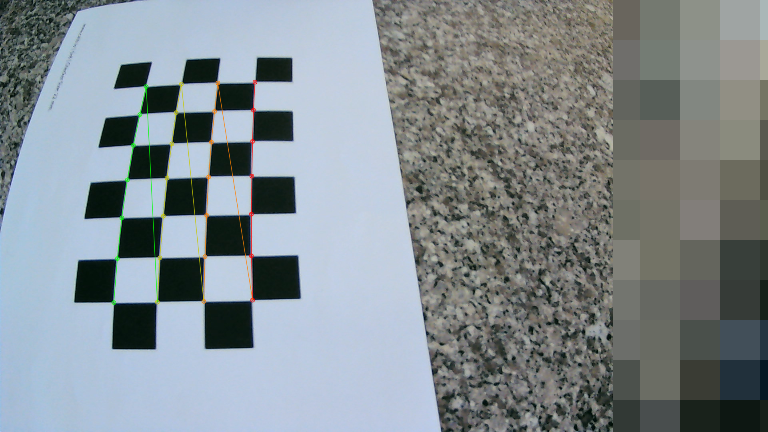

In [5]:
SQUARE_SIZE = 21

# prepare object points (i.e., real world points)
objp = np.zeros((4*7,3), np.float32)  
objp[:,:2] = (SQUARE_SIZE*np.mgrid[0:7,0:4]).T.reshape(-1,2)

# arrays to store object points and image points from all the images
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane

# termination criteria for the cv.cornerSubPix() function
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in images_intrinsic:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,4), None)
    # if found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        # draw and display the corners
        cv.drawChessboardCorners(img, (7,4), corners2, ret)
        #cv2_imshow(img)

# just show "draw and display the corners" on the last image
small_img = cv.resize(img, (0,0), fx=0.40, fy=0.40)
cv2_imshow(small_img)

`calibrateCamera()` function finds the camera **intrinsic** and **extrinsic** parameters from several views of a calibration pattern.

The algorithm performs the following steps:

* Compute the initial intrinsic parameters (the option only available for planar calibration patterns) or read them from the input parameters. The distortion coefficients are all set to zeros initially unless some of `CALIB_FIX_K?` are specified.

* Estimate the initial camera pose as if the intrinsic parameters have been already known. This is done using `solvePnP()`.

* Run the global Levenberg-Marquardt optimization algorithm to minimize the reprojection error, that is, the total sum of squared distances between the observed feature points imagePoints and the projected (using the current estimates for camera parameters and the poses) object points objectPoints.

From: <https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d>

In [6]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [7]:
print('camera matrix (or intrinsic matrix) \n', mtx, '\n')
print('distortion coefficients \n', dist)

camera matrix (or intrinsic matrix) 
 [[1.32164964e+03 0.00000000e+00 9.88299720e+02]
 [0.00000000e+00 1.32444624e+03 6.42259045e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

distortion coefficients 
 [[-3.44269868e-01  9.00566925e-02  9.45446381e-05 -3.97945884e-04
  -3.15663097e-03]]


In [8]:
#print('rotation vectores \n', rvecs, '\n')
#print('translation vectors \n', tvecs)

**Reprojection Error**

`calibrateCamera()` function returns the overall RMS reprojection error.

From: <https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d>

In [9]:
# overall root mean squared (RMS) reprojection error
print('RMS reprojection error:', ret)

RMS reprojection error: 0.49167717469524636


The reprojection error is a geometric error corresponding to the image distance between a projected point and a measured one.

From: <https://en.wikipedia.org/wiki/Reprojection_error>

Reprojection error gives a good estimation of just how exact the found parameters are. The closer the reprojection error is to zero, the more accurate the parameters we found are.

Given the intrinsic, distortion, rotation and translation matrices, we must first transform the object point to image point using `cv.projectPoints()`. Then, we can calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error, we calculate the arithmetical mean of the errors calculated for all the calibration images.

*Reference*: <https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html> (see the bottom of the page).

In [10]:
# Mean Reprojection Error
# and RMS Reprojection Error (to confirm)

sum_error = 0
sum_squared_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    for j in range(len(imgpoints2)):
        error = cv.norm(imgpoints[i][j], imgpoints2[j], cv.NORM_L2) # reprojection erro (using the Euclidean distance)
        sum_error += error
        sum_squared_error += error**2

print( 'Mean reprojection error: {}'.format(sum_error/(len(imgpoints2)*len(objpoints))) )
print( 'RMS reprojection error: {}'.format((sum_squared_error/(len(imgpoints2)*len(objpoints)))**(1/2)) )

Mean reprojection error: 0.4000669735865279
RMS reprojection error: 0.49167707772305735


## **b)** Calibration of the extrinsic parameters of the camera setup.

**Extrinsic parameters** correspond to rotation and translation vectors which translate coordinates of a 3D point to a 2D coordinate system.

From: <https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html>

For this part of the assignment, we will be using the chess board image in the white background folder, as we assume that all images in this folder were produced with the camera in a **static position** (as shown in Figure 1 of the assignment).

In [11]:
whiteb_extrinsic = cv.imread('/content/drive/MyDrive/CV/CV_Assig_1/WhiteBackground/extrinsic.png')

In [12]:
gray_ext = cv.cvtColor(whiteb_extrinsic, cv.COLOR_BGR2GRAY)
# find the chess board corners
ret_ext, corners_ext = cv.findChessboardCorners(gray_ext, (7,4), None)
# refine the chess board corners
corners2_ext = cv.cornerSubPix(gray_ext, corners_ext, (11,11), (-1,-1), criteria)

In [13]:
# prepare object points (i.e., real world points)
objp = np.zeros((4*7,3), np.float32)  
objp[:,:2] = (SQUARE_SIZE*np.mgrid[0:7,0:4]).T.reshape(-1,2)
# determine rotation vector and translation vector
sucess, rvec_ext, tvec_ext = cv.solvePnP(objp, corners2_ext, mtx, dist)
print(sucess)
print(rvec_ext)
print(tvec_ext)

True
[[-0.00383021]
 [ 0.02256792]
 [ 3.13820054]]
[[ 71.00528094]
 [ -3.47044008]
 [227.45935239]]


Place an axis on the image using the extrinsic calibration.

From: <https://docs.opencv.org/3.4/d7/d53/tutorial_py_pose.html>

In [14]:
axis = np.float32([[21,0,0], [0,21,0], [0,0,-21]]).reshape(-1,3) # to occupy the side of a square

In [15]:
imgpts_ext, jac_ext = cv.projectPoints(axis, rvec_ext, tvec_ext, mtx, dist)

In [16]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img

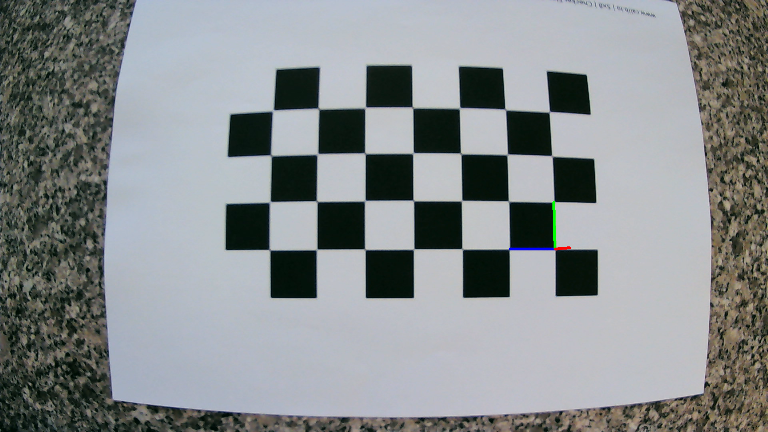

In [17]:
img_axis = whiteb_extrinsic.copy()
img_axis = draw(img_axis, corners2_ext, imgpts_ext)
small_img_axis = cv.resize(img_axis, (0,0), fx=0.40, fy=0.40)
cv2_imshow(small_img_axis)

**Conversion pixel-millimeter**

*Recall*: The side of each square is 21mm.

* In the **distorted** image, the number of pixels that correspond to the side of a square depends on the square location on the image. In this case, we have a *barrel distortion*, so squares at the center occupy more pixels than the ones on the edges.

* However, in the **undistorted** image, we should have consistency in the number of pixels that correspond to the side of a square.

Undistort the image and crop.

From: <https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html>

(775, 1663, 3)


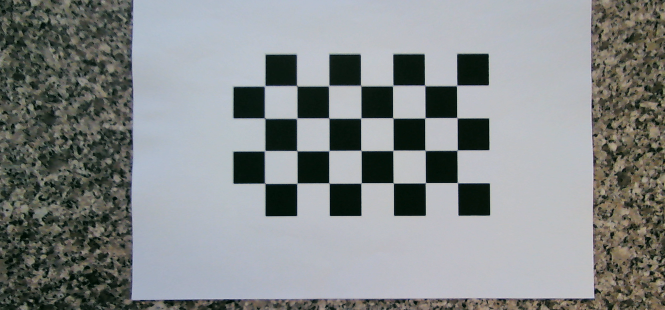

In [18]:
h, w = whiteb_extrinsic.shape[:2]
newcameramtx_und, roi_und = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
und_extrinsic = cv.undistort(whiteb_extrinsic, mtx, dist, None, newcameramtx_und)
# crop the image
x, y, w, h = roi_und
und_extrinsic = und_extrinsic[y:y+h, x:x+w]
print(und_extrinsic.shape)
small_und_extrinsic = cv.resize(und_extrinsic, (0,0), fx=0.40, fy=0.40)
cv2_imshow(small_und_extrinsic)

In [19]:
gray_und = cv.cvtColor(und_extrinsic, cv.COLOR_BGR2GRAY)
# find the chess board corners
ret_und, corners_und = cv.findChessboardCorners(gray_und, (7,4), None)
# refine the chess board corners
corners2_und = cv.cornerSubPix(gray_und, corners_und, (11,11), (-1,-1), criteria)
print(corners2_und[:,0])

[[1144.1752   457.18997]
 [1063.8672   457.4871 ]
 [ 983.76196  457.87296]
 [ 903.4434   458.20035]
 [ 823.2684   458.33432]
 [ 743.20166  458.54187]
 [ 662.5986   458.85416]
 [1143.5076   375.97406]
 [1063.2002   376.2612 ]
 [ 983.244    376.51837]
 [ 903.0341   376.62656]
 [ 823.07184  376.98267]
 [ 742.76434  377.2315 ]
 [ 662.4157   377.30176]
 [1142.9214   294.73843]
 [1062.889    295.10043]
 [ 982.96027  295.50235]
 [ 902.7691   295.69693]
 [ 822.61127  295.87643]
 [ 742.7378   295.93707]
 [ 662.352    296.12155]
 [1142.3937   214.08766]
 [1062.258    214.16803]
 [ 982.62164  214.35823]
 [ 902.54584  214.7099 ]
 [ 822.41986  214.66194]
 [ 742.5199   214.83392]
 [ 662.44965  215.16122]]


From the above coordinates, we can see that, in this undistorted image, the detected corners are almost perfectly aligned. Thus, the difference between its coordinates should give the same values, which is the number of pixels that corresponds to the side of a square.

In [20]:
x = [np.mean([corners2_und[:,0][i][0] for i in [0+j, 7+j, 14+j, 21+j]]) for j in range(0,7)]
y = [np.mean([corners2_und[:,0][i][1] for i in range(j,j+7)]) for j in range(0,22,7)]
pix_mil = np.mean([x[i]-x[i+1] for i in range(0,6)])*(len(x)-1)/(len(x)-1+len(y)-1) + np.mean([y[i]-y[i+1] for i in range(0,3)])*(len(y)-1)/(len(x)-1+len(y)-1)
print('The side of a square, which is 21mm, corresponds to approximately', round(pix_mil,1), 'pixels in the undistorted image.')

The side of a square, which is 21mm, corresponds to approximately 80.5 pixels in the undistorted image.


## **c)** Considering only the images retrieved from a **White Background**:

As stated previously, we assume all images in the WhiteBackground folder were produced with the camera in the same static position and that the white background (i.e., the white sheet of paper) does not change place.

In [21]:
whiteb_images = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/WhiteBackground/calib_img*.png')

### **I.** Define a ROI (region of interest);

In this case, the ROI will be the white sheet of paper. To determine the mask for the ROI, the best image to use is `calib_img 0.png`, which only has the white sheet of paper (without M&M on top of it).

Steps: **completar**
1. 
2. 

In [22]:
# to undistort and crop, the newcameramtx and roi stay the same as in the image
# used for the extrinsic calibration

def own_undistort(img, mtx, dist):
    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx_und)
    # crop the image
    x, y, w, h = roi_und
    dst = dst[y:y+h, x:x+w]
    return dst

## **c)** Considering only the images retrieved from a **White Background**:

In [23]:
images = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/WhiteBackground/calib_img*.png')  # Changed folder

### **I.** Define a ROI (region of interest);

In [38]:
images_corrected = []               # undistort 
for fname in images:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = own_undistort(img, mtx, dist)
    img = cv.resize(img, (0,0), fx=0.4, fy=0.4) ## resize by n% to be faster pffffff ;)
    #cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
    #print("\n")
    images_corrected.append(img)

#### **Aproach 1.**

In [39]:
# vou a 1ª imagem e retiro a mascara do que é branco. A câmara esta sempre naquela posição portanto nas outras imagens, os m&m vão estar sempre
# naquela zona branca

"""
for img in images_corrected:
  img = cv.medianBlur(img,9)
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # white
  sensitivity = 100
  lower_white = (0,0,255-sensitivity)
  upper_white = (255,sensitivity,255)
  mask_white = cv.inRange(img_hsv, lower_white, upper_white)
  mask_image = cv.bitwise_and(img_hsv, img_hsv, mask=mask_white)
  img_white = cv.cvtColor(mask_image, cv.COLOR_HSV2BGR)
  #cv2_imshow(img_white)
  #print("\n")
  break

# aplico a mascara da 1ª imagem nas outras e removo o granito das imagens 
images_roi_defined = []    
images_corrected.pop(0)  # remove a 1ª imagem que só tem a folha de papel          
for img in images_corrected:
  img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  img = cv.bitwise_and(img,img,mask = mask_white)   
  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
  images_roi_defined.append(img)
  #cv2_imshow(img)
  #print("\n")

"""
print("Aproach 1 with less quality")

Aproach 1 with less quality


#### **Aproach 2.**

In [40]:
# alternativa usando a imagem binária
# Load image
img = images_corrected[0].copy()
#cv2_imshow(img)
#print("\n")

# Convert to grayscale
gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
gray = cv.medianBlur(gray,9)
# Convert to binary
threshold, max_value = 165, 255
binary = cv.threshold(gray, threshold, max_value, cv.THRESH_BINARY)[1]

kernel = np.ones((15, 15), 'uint8')
binary = cv.erode(binary, kernel, iterations=3)
#cv2_imshow(binary)
#print("\n")

images_roi_defined = []    
images_corrected.pop(0)  # remove a 1ª imagem que só tem a folha de papel          
for img in images_corrected:
  img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  img = cv.bitwise_and(img,img,mask = binary)   
  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)
  img = cv.medianBlur(img,9)
  images_roi_defined.append(img)
  #cv2_imshow(img)
  #print("\n")

### **II.** Calculate the color distribution (up to 4);

## Notes: 
###Histogram Equalization <br>
#### * It is a graphical representation of the intensity distribution of an image. <br>
#### * It quantifies the number of pixels for each intensity value considered


In [41]:
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

In [42]:
# color ranges

# red low
lower_red, upper_red = (0, 100, 100), (10, 255, 255)
# red high
lower_red_h, upper_red_h = (150, 100, 100), (180, 255, 255)
# green
lower_green, upper_green = (35,50,0), (90,255,255)
# blue
lower_blue, upper_blue = (90,100,60), (120,255,255)
# yellow
lower_yellow, upper_yellow = (20,100,100), (35,255,255)
# brown
lower_brown, upper_brown = (10,100,20), (20,255,200)

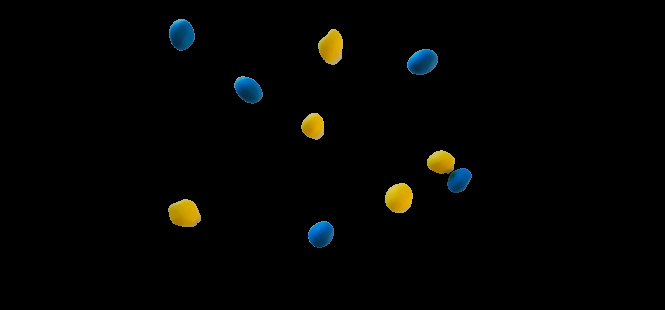



Red: [34.4]%; Green: [38.55]%; Blue: [27.05]%
___________________________________________



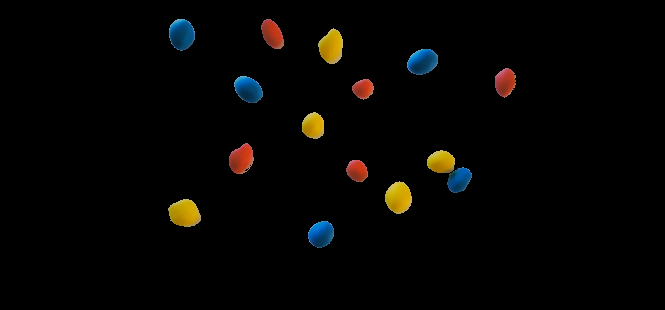



Red: [34.15]%; Green: [36.86]%; Blue: [28.99]%
___________________________________________



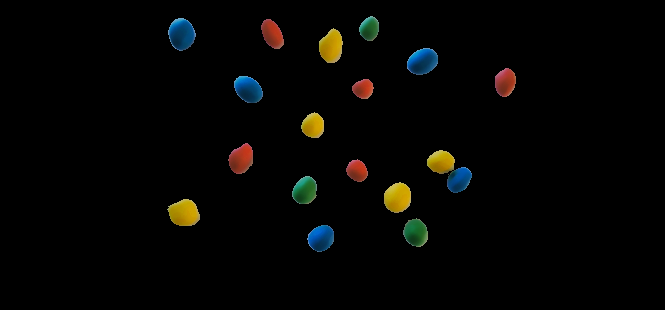



Red: [33.94]%; Green: [36.02]%; Blue: [30.05]%
___________________________________________



In [43]:
images_only_with_MandM = []
masks_data = [] # tuple with masks for each image (Red Mask, Green Mask, Blue Mask, Yellow Mask)
masks_combined_data = [] #list with mask of all m&m (independent of color)

for img in images_roi_defined:
  img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  #cv2_imshow(img)
  #print("\n")

  # Red
  mask_red_low = cv.inRange(img_hsv, lower_red, upper_red)
  mask_red_high = cv.inRange(img_hsv, lower_red_h, upper_red_h)
  # combine masks
  mask_red = cv.bitwise_or(mask_red_low, mask_red_high) 
  img_red = cv.bitwise_or(img_hsv, img_hsv, mask=mask_red)
  #cv2_imshow(img_red)

  # green
  mask_green = cv.inRange(img_hsv, lower_green, upper_green)
  img_green = cv.bitwise_and(img_hsv, img_hsv, mask=mask_green)
  #cv2_imshow(img_green)

  # blue
  mask_blue = cv.inRange(img_hsv, lower_blue, upper_blue)
  img_blue = cv.bitwise_and(img_hsv, img_hsv, mask=mask_blue)
  #cv2_imshow(img_blue)

  # yellow
  mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
  img_yellow = cv.bitwise_and(img_hsv, img_hsv, mask=mask_yellow)
  #cv2_imshow(img_yellow)

  combined_masks = cv.bitwise_or(mask_blue, mask_red)
  combined_masks = cv.bitwise_or(combined_masks, mask_yellow) 
  combined_masks = cv.bitwise_or(combined_masks, mask_green)

  img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks)
  img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
  cv2_imshow(img_roi_bgr)
  print("\n")

  masks_data.append((mask_red,mask_green,mask_blue,mask_yellow))
  images_only_with_MandM.append(img_roi_bgr) 
  masks_combined_data.append(combined_masks)

  color = ('b','g','r')
  qtdBlue = 0
  qtdGreen = 0
  qtdRed = 0
  totalPixels = 0

  for channel,col in enumerate(color):
    histr = cv.calcHist([img_roi_bgr],[channel],None,[256],[1,256])

    totalPixels+=sum(histr)
    if channel==0:
     qtdBlue = sum(histr)
    elif channel==1:
      qtdGreen = sum(histr)
    elif channel==2:
      qtdRed = sum(histr)
  
  qtdBlue = (qtdBlue/totalPixels)*100
  qtdGreen = (qtdGreen/totalPixels)*100
  qtdRed = (qtdRed/totalPixels)*100

  print("Red: "+str(np.round(qtdRed,2))+"%; Green: "+str(np.round(qtdGreen,2))+"%; Blue: "+str(np.round(qtdBlue,2))+"%")
  print("___________________________________________\n")


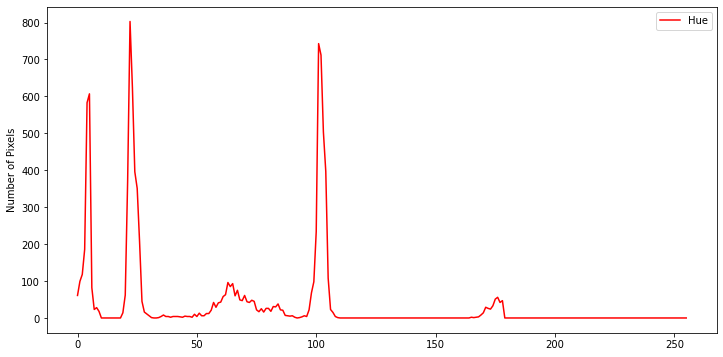

In [44]:
img2 = cv.cvtColor(images_only_with_MandM[-1], cv.COLOR_BGR2HSV)
h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
hist_h = cv.calcHist([h],[0],None,[256],[1,256])
hist_s = cv.calcHist([s],[0],None,[256],[1,256])
hist_v = cv.calcHist([v],[0],None,[256],[1,256])

fig = plt.figure(figsize=(12,6))
plt.plot(hist_h, color='r', label="Hue")
#plt.plot(hist_s, color='g', label="s")
#plt.plot(hist_v, color='b', label="Value")
plt.ylabel("Number of Pixels")
plt.legend()
plt.show()

### **III**. Determine the shape area for the chocolate peanuts in pixels;

In [45]:
# se soubermos a area de cada pixel podemos somente multiplicar pelo nr de pixeis e temos a area de m&m na imagem
for image_index, i in enumerate(masks_combined_data):
  print("Total area of chocolate peanuts in image {} = {}".format(image_index+1, np.sum(i)))

Total area of chocolate peanuts in image 1 = 1491495
Total area of chocolate peanuts in image 2 = 2057595
Total area of chocolate peanuts in image 3 = 2431425


### **IV**. Determine the shape area for chocolate peanuts in millimeters and group by color;

In [46]:
#valor arbitrario
area_pixel = 0.00025

Area of Red in image 0 = 0.0
Area of Green in image 0 = 0.57
Area of Blue in image 0 = 179.52
Area of Yellow in image 0 = 192.91




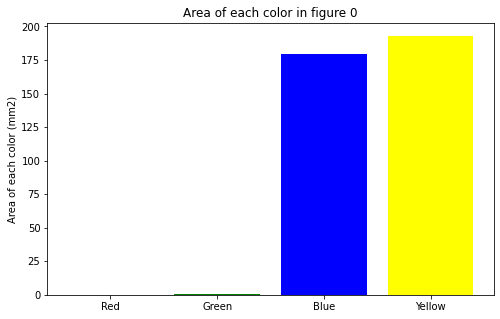

---------------------------------------------------------------

Area of Red in image 1 = 141.27
Area of Green in image 1 = 0.57
Area of Blue in image 1 = 181.56
Area of Yellow in image 1 = 191.0




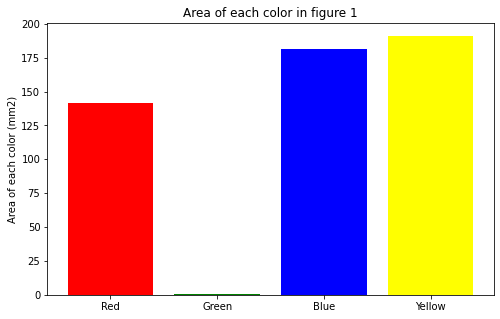

---------------------------------------------------------------

Area of Red in image 2 = 140.76
Area of Green in image 2 = 93.78
Area of Blue in image 2 = 188.32
Area of Yellow in image 2 = 185.26




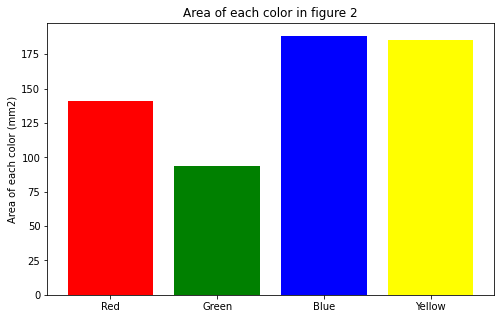

---------------------------------------------------------------



In [47]:
# se soubermos a area de cada pixel podemos somente multiplicar pelo nr de pixeis da mascara de cada cor e temos a area de m&m de cada cor na imagem
colors = ['Red', 'Green', 'Blue', 'Yellow']
for img_nr, i in enumerate(masks_data): 
  vals = [] # value of each color for bar plot
  for nr, j in enumerate(i):
    vals.append(np.sum(j)*area_pixel)
    print("Area of {} in image {} = {}".format(colors[nr], img_nr, np.round(np.sum(j)*area_pixel,2)))
  print("\n") 

  fig = plt.figure(figsize=(8,5))
  plt.bar(colors, vals, color=colors)
  plt.ylabel("Area of each color (mm2)")
  plt.title('Area of each color in figure {}'.format(img_nr))
  plt.show()

  print("---------------------------------------------------------------\n")   


### **V**. Show a histogram of the shape areas of the chocolate peanuts for the entire sample;

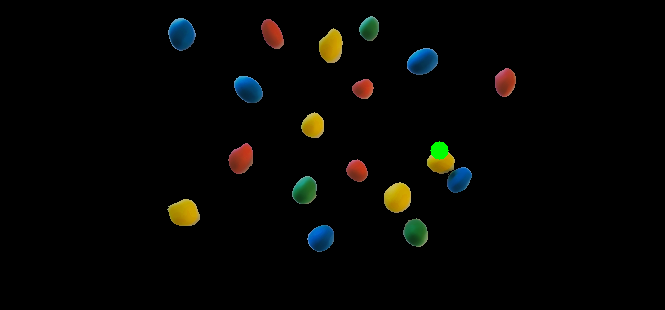

In [48]:
n = 8
teste = (masks_combined_data[2])
contours, my_hierarchy = cv.findContours(teste, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

sorted_contours= sorted(contours, key=cv.contourArea, reverse = True)
sorted_contours2 = sorted_contours[0][0:n].copy()

#print("len(sorted_contours)", len(sorted_contours2))
#print("sorted_contours)", (sorted_contours2))

cv2_imshow(cv.drawContours(images_only_with_MandM[2], sorted_contours2, -1, (0,255,0), 17, cv.FILLED, maxLevel=-1,  ))
# precisamos entender melhor esta função. podemos definir o n em função de um treshold na area do sorted dada pelo argumento "key" !!!
print("\n")

### **VI**. Provide some recommendations that the M&M factory should take into consideration to improve the performance of the quality assurance process based on image processing (e.g., imaging setup, calibration process and photometric effects).

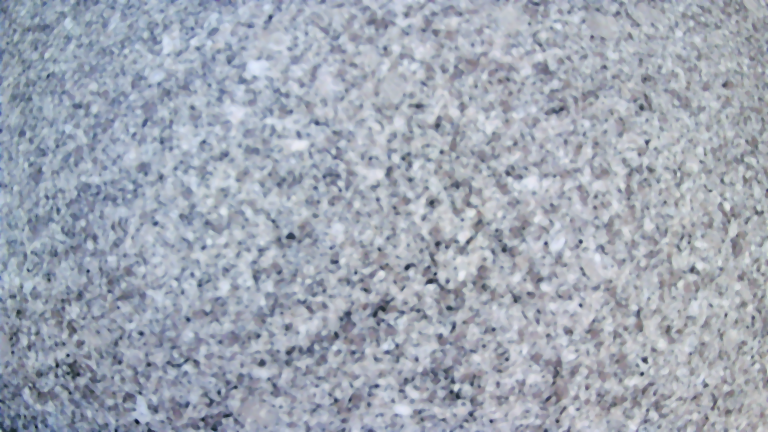

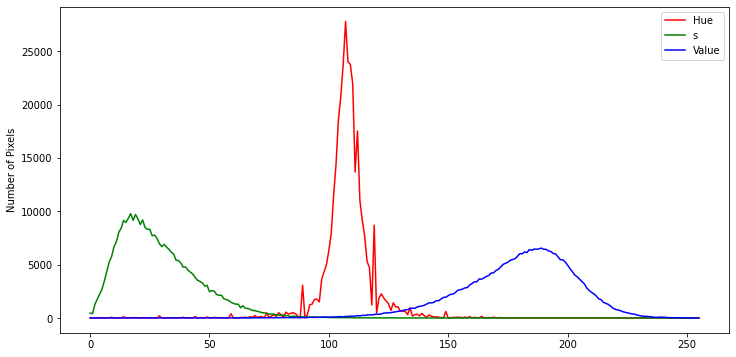

In [49]:
images_grey_back = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/GreyBackground/calib_img 0.png')  # Changed folder

for fname in images_grey_back:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #img = own_undistort(img, mtx, dist)
    img = cv.resize(img, (0,0), fx=0.4, fy=0.4) ## resize by n% to be faster pffffff ;)
    cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
    print("\n")
    img2 = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv.calcHist([h],[0],None,[256],[1,256])
    hist_s = cv.calcHist([s],[0],None,[256],[1,256])
    hist_v = cv.calcHist([v],[0],None,[256],[1,256])

    fig = plt.figure(figsize=(12,6))
    plt.plot(hist_h, color='r', label="Hue")
    plt.plot(hist_s, color='g', label="s")
    plt.plot(hist_v, color='b', label="Value")
    plt.ylabel("Number of Pixels")
    plt.legend()
    plt.show()
    break

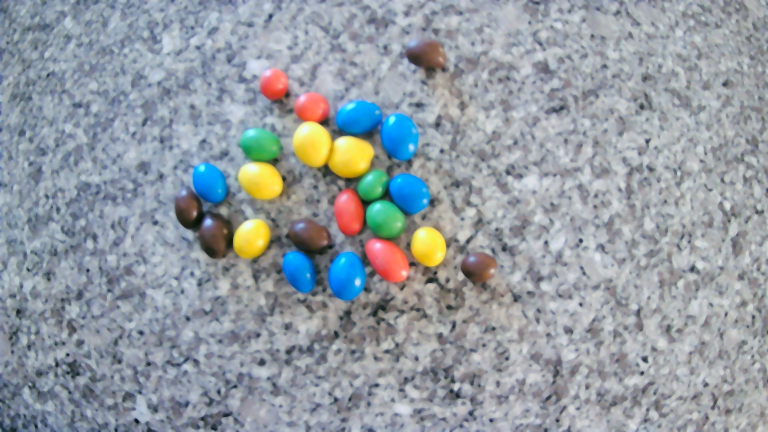

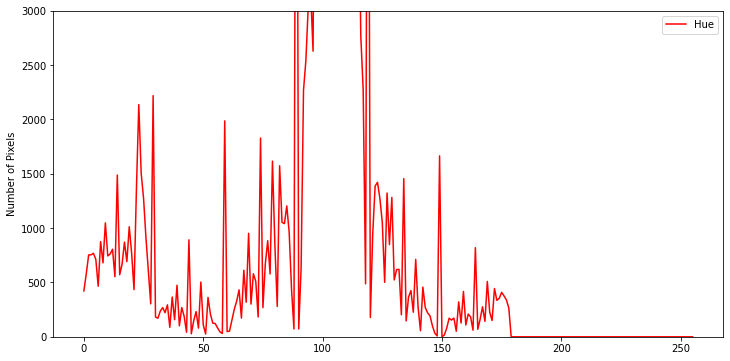

In [50]:
images_grey_back = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/GreyBackground/calib_img 5.png')  # Changed folder

for fname in images_grey_back:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #img = own_undistort(img, mtx, dist)
    img = cv.resize(img, (0,0), fx=0.4, fy=0.4) ## resize by n% to be faster pffffff ;)
    cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
    print("\n")
    img2 = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv.calcHist([h],[0],None,[256],[1,256])
    hist_s = cv.calcHist([s],[0],None,[256],[1,256])
    hist_v = cv.calcHist([v],[0],None,[256],[1,256])

    fig = plt.figure(figsize=(12,6))
    plt.plot(hist_h, color='r', label="Hue")
    plt.ylim([0, 3000])
   # plt.plot(hist_s, color='g', label="s")
   # plt.plot(hist_v, color='b', label="Value")
    plt.ylabel("Number of Pixels")
    plt.legend()
    plt.show()
    break

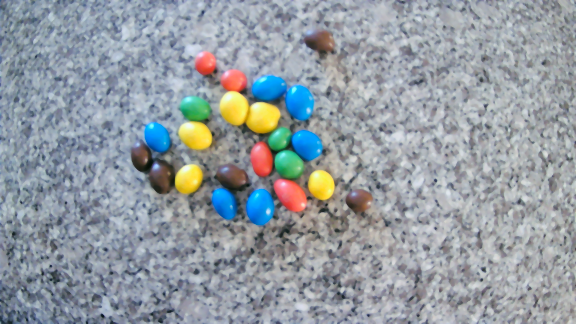

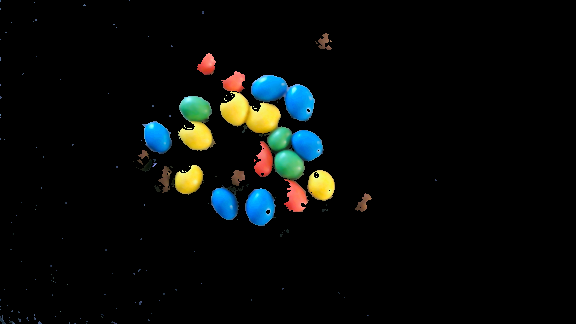

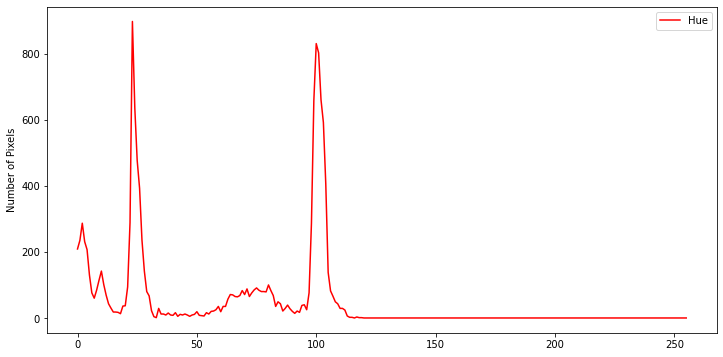

In [51]:
images_grey_back = glob.glob('/content/drive/MyDrive/CV/CV_Assig_1/GreyBackground/calib_img 5.png')  # Changed folder

for fname in images_grey_back:
    img = cv.imread(fname)
    img = cv.medianBlur(img,9)
    img = cv.resize(img, (0,0), fx=0.3, fy=0.3) ## resize by n% to be faster pffffff ;)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    #img = own_undistort(img, mtx, dist)
    cv2_imshow(img)   # Changed from 'img' to fname so that all windows are kept open
    print("\n")

    mask_red_low = cv.inRange(img_hsv, lower_red, upper_red)
    mask_red_high = cv.inRange(img_hsv, lower_red, upper_red)
    # combine masks
    mask_red = cv.bitwise_or(mask_red_low, mask_red_high) 
    img_red = cv.bitwise_or(img_hsv, img_hsv, mask=mask_red)
    #cv2_imshow(img_red)

    # green
    mask_green = cv.inRange(img_hsv, lower_green, upper_green)
    img_green = cv.bitwise_and(img_hsv, img_hsv, mask=mask_green)
    #cv2_imshow(img_green)

    # blue
    mask_blue = cv.inRange(img_hsv, lower_blue, upper_blue)
    img_blue = cv.bitwise_and(img_hsv, img_hsv, mask=mask_blue)
    #cv2_imshow(img_blue)

    # yellow
    mask_yellow = cv.inRange(img_hsv, lower_yellow, upper_yellow)
    img_yellow = cv.bitwise_and(img_hsv, img_hsv, mask=mask_yellow)
    #cv2_imshow(img_yellow)

    # brown
    mask_brown = cv.inRange(img_hsv, lower_brown, upper_brown)
    img_brown = cv.bitwise_and(img_hsv, img_hsv, mask=mask_brown)
    #cv2_imshow(img_yellow)

    combined_masks = cv.bitwise_or(mask_blue, mask_red)
    combined_masks = cv.bitwise_or(combined_masks, mask_yellow) 
    combined_masks = cv.bitwise_or(combined_masks, mask_green)
    combined_masks = cv.bitwise_or(combined_masks, mask_brown)

    img_roi = cv.bitwise_and(img_hsv, img_hsv, mask=combined_masks)
    img_roi_bgr = cv.cvtColor(img_roi, cv.COLOR_HSV2BGR)
    cv2_imshow(img_roi_bgr)
    print("\n")

    img2 = cv.cvtColor(img_roi_bgr, cv.COLOR_BGR2HSV)
    h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
    hist_h = cv.calcHist([h],[0],None,[256],[1,256])
    hist_s = cv.calcHist([s],[0],None,[256],[1,256])
    hist_v = cv.calcHist([v],[0],None,[256],[1,256])

    fig = plt.figure(figsize=(12,6))
    plt.plot(hist_h, color='r', label="Hue")
    #plt.plot(hist_s, color='g', label="s")
    #plt.plot(hist_v, color='b', label="Value")
    plt.ylabel("Number of Pixels")
    plt.legend()
    plt.show()